In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

In [2]:
import seaborn as sns
import pandas as pd

learning_types = ['base', 'attention_induction', 'ltr']
random_states = ['2023', '2024', '2025', '2026', '2027']

all_rows = []
for learning in learning_types:
    for random_state in random_states:
        rows = mlflow.search_runs(
            experiment_names=["attention_induction"],
            filter_string=(
                f"params.learning = '{learning}' "
                f"and params.random_state = '{random_state}' "
                f"AND params.margin = '1.0' "
            )
        )
        if "params.morphology_value" in rows.columns:
            rows = rows[(rows["params.morphology_value"].isna() & rows["params.dataset"].isna())]
        else:
            rows = rows
        all_rows.append(rows)


# 모든 결과를 하나의 DataFrame으로 합치기
data = pd.concat(all_rows).reset_index(drop=True)
data["params.sampling_ratio"] = data["params.sampling_ratio"].astype(float)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "params.learning", "params.sampling_ratio"]]

# rename
data_view["params.learning"] = data_view["params.learning"].replace({"base":"AB-MIL", "attention_induction": "Attention induction", "ltr":"Rank induction"})

/tmp/ipykernel_2186821/1865732960.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view["params.learning"] = data_view["params.learning"].replace({"base":"AB-MIL", "attention_induction": "Attention induction", "ltr":"Rank induction"})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0.4_Attention induction v.s. 0.4_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=2.857e-02 U_stat=1.000e+00
0.6_Attention induction v.s. 0.6_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.429e-02 U_stat=0.000e+00
0.8_Attention induction v.s. 0.8_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.714e-01 U_stat=4.000e+00
1.0_Attention induction v.s. 1.0_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.010e-01 U_stat=9.000e+00
0.2_Attention induction v.s. 0.2_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=2.429e-01 U_stat=5.000e+00
0.6_AB-MIL v.s. 0.6_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.429e-02 U_stat=0.000e+00
0.8_AB-MIL v.s. 0.8_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=4.429e-01 U_stat=7.000e+00
1.0_AB-MIL v.s. 1.0_Rank induction: 

(<Axes: xlabel='Sampling Ratio (Fraction of Training Data Used)', ylabel='AUROC'>,
  <statannot.StatResult.StatResult at 0x7f58b27232e0>])

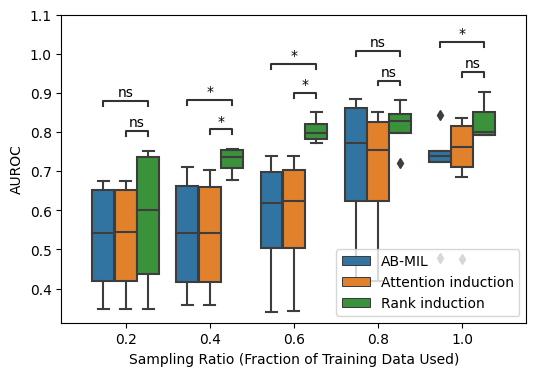

In [3]:
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=data_view, x="params.sampling_ratio", y="metrics.test_auroc", hue="params.learning")
ax.set_xlabel("Sampling Ratio (Fraction of Training Data Used)")
ax.set_ylabel("AUROC")
ax.legend(loc="lower right")

comparsions = list()
sampling_ratios = sorted(data_view["params.sampling_ratio"].unique())
for ratio in sampling_ratios:
    # 각 sampling ratio에 대한 비교 쌍 생성
    comparison = [
        ((ratio, "AB-MIL"), (ratio, "Rank induction")),
        ((ratio, "Attention induction"), (ratio, "Rank induction"))
    ]
    comparsions.extend(comparison)
    
add_stat_annotation(
    ax,
    data=data_view,
    x="params.sampling_ratio",
    y="metrics.test_auroc",
    hue="params.learning",
    box_pairs=comparsions,
    test="Mann-Whitney-ls",  # or "t-test_ind"
    text_format="star",
    loc="inside",
    verbose=2,
    comparisons_correction=None  # 다중 비교 보정 제거
)


In [15]:
from tableone import TableOne
data_view.groupby(["params.learning", "params.sampling_ratio"]).describe()

metrics.test_auroc            \
                                                       count      mean   
params.learning     params.sampling_ratio                                
AB-MIL              0.2                                  4.0  0.527105   
                    0.4                                  4.0  0.537755   
                    0.6                                  4.0  0.580166   
                    0.8                                  4.0  0.712564   
                    1.0                                  5.0  0.707449   
Attention induction 0.2                                  4.0  0.527360   
                    0.4                                  4.0  0.535969   
                    0.6                                  4.0  0.581952   
                    0.8                                  4.0  0.695281   
                    1.0                                  7.0  0.732653   
Rank induction      0.2                                  4.0  0.575000   
                    0.4                                  4.0  0.726977   
                    0.6                                  4.0  0.804719   
                    0.8                                  4.0  0.815051   
                    1.0                                  5.0  0.828316   

                                                                         \
                                                std       min       25%   
params.learning     params.sampling_ratio                                 
AB-MIL              0.2                    0.158332  0.346684  0.418814   
                    0.4                    0.167203  0.357653  0.417538   
                    0.6                    0.177053  0.340816  0.502679   
                    0.8                    0.213164  0.419133  0.623661   
                    1.0                    0.137059  0.477041  0.724235   
Attention induction 0.2                    0.158259  0.346684  0.419388   
                    0.4                    0.164864  0.357908  0.417219   
                    0.6                    0.177586  0.341582  0.503444   
                    0.8                    0.197251  0.418367  0.623087   
                    1.0                    0.125070  0.475510  0.711352   
Rank induction      0.2                    0.199522  0.347704  0.437628   
                    0.4                    0.037641  0.677041  0.708418   
                    0.6                    0.034714  0.772194  0.781378   
                    0.8                    0.068478  0.719898  0.796620   
                    1.0                    0.048995  0.791837  0.792602   

                                                                         \
                                                50%       75%       max   
params.learning     params.sampling_ratio                                 
AB-MIL              0.2                    0.542985  0.651276  0.675765   
                    0.4                    0.541582  0.661798  0.710204   
                    0.6                    0.619770  0.697258  0.740306   
                    0.8                    0.773342  0.862245  0.884439   
                    1.0                    0.739541  0.752041  0.844388   
Attention induction 0.2                    0.543495  0.651467  0.675765   
                    0.4                    0.541327  0.660077  0.703316   
                    0.6                    0.623980  0.702487  0.738265   
                    0.8                    0.754974  0.827168  0.852806   
                    1.0                    0.763265  0.815816  0.835459   
Rank induction      0.2                    0.599745  0.737117  0.752806   
                    0.4                    0.736480  0.755038  0.757908   
                    0.6                    0.798087  0.821429  0.850510   
                    0.8                    0.828954  0.847385  0.882398   
                    1.0                    0.801276  0.852041  0.903827   

       